# Bonds 2

This notebook discusses duration hedging as a way to immunize a bond portfolio.

## Load Packages and Extra Functions

In [1]:
using Dates, Roots

include("jlFiles/printmat.jl")

printwhere (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

## From the Notebook on Bonds 1

The file included below contains the function `BondPrice3()` which calculates the present value of a cash flow stream.

In [3]:
include("jlFiles/BondCalculations.jl")

BondPrice3

# Value of a Liability after a Sudden Interest Rate Change

The calculations below assume that the yield curve is flat, but that it can shift up or down in parallel. This assumption is similar to the classical literature on duration hedging.

The initial values are indicated by the subscript $_0$ and the values after the interest rate change by the subscript $_1$. It is assumed that the change is very sudden, so the time to the different cash flows is (virtually) the same before and after.

The next cell sets up the cash flow for a liability that pays 0.2 each year for the next 10 years. The value of the liability is calculated at an initial interest rate ($\theta_0$) and at a new interest rate ($\theta_1$).

In [4]:
θ₀ = 0.05                   #initial interest rate
θ₁ = 0.03                   #interest rate after sudden change

cf = fill(0.2,10)           #cash flow of liability
m  = 1:10                   #time periods of the cash flows

P₀ = BondPrice3(θ₀,cf,m)
P₁ = BondPrice3(θ₁,cf,m)
R = (P₁ - P₀)/P₀

printblue("As θ changes from θ₀=$θ₀ to θ₁=$θ₁:")
xy = [P₀, P₁, R]
printTable(xy,[" "],["P₀";"P₁";"ΔP/P₀"],width=15)

printred("Notice that the liability is worth more at the lower interest rate")

As θ changes from θ₀=0.05 to θ₁=0.03:
                    
P₀             1.544
P₁             1.706
ΔP/P₀          0.105

Notice that the liability is worth more at the lower interest rate


# Macaulay's Duration

A first-order Taylor approximation gives

$\frac{\Delta P}{P} = -D^M \times \frac{\Delta \theta}{1+\theta}$, 

where $D^M$ is Macaulay's duration

$D^M = \sum_{k=1}^{K} m_{k}\frac{cf_{k}}{\left(  1+\theta\right)  ^{m_{k}}P}$

In [5]:
"""
    BondDuration(P,cf,m,ytm)

Calculate Macaulays (bond) duration measure.

P:   scalar, bond price
cf:  scalar or K vector of cash flows
m:   K vector of times of cash flows
ytm: scalar, yield to maturity
"""
function BondDuration(P,cf,m,ytm)
    cdisc   = cf.*m./((1+ytm).^m)        #c/(1+y) + 2c/(1+y)^2 + ...
    Dmac    = sum(cdisc)/P               #Macaulays duration
    return Dmac
end

BondDuration

In [6]:
Dmac    = BondDuration(P₀,cf,m,θ₀)
printlnPs("Macaulay's duration",Dmac)

Δθ       = θ₁ - θ₀
R_approx = -Dmac*Δθ/(1+θ₀)

println("\nExact and approximate relative price change: ")
printlnPs(R,R_approx)

Macaulay's duration     5.099

Exact and approximate relative price change: 
     0.105     0.097


# Hedging a Liability Stream

Suppose we are short one bond $L$ (this is the liability), which is worth $P_L$. To hedge that we buy $v$ units of bond $H$. The balance is put on a money market account $M$ to make the initial value of the portfolio zero ($V=0$)

$V=vP_{H}+M-P_{L}$.

Over a short time interval, the change in the portfolio value is

$\Delta V=v\Delta P_{H}-\Delta P_{L}$.

In the cells below, we assume that the yield curve is flat and shifts in parallel. This means that the ytm of both instruments change from one common value ($\theta_0$) to another common value ($\theta_1$).

In [7]:
PL₀ = P₀        #just switching notation: this is the value of the liability
PL₁ = P₁

printblue("Value of liability at different interest rates θ₀ and $θ₁:")
printTable([PL₀,PL₁],[""],["PL₀","PL₁"])

printblue("Macaulay's duration of the liability:")
printlnPs(Dmac)

Value of liability at different interest rates θ₀ and 0.03:
             
PL₀     1.544
PL₁     1.706

Macaulay's duration of the liability:
     5.099


## Duration Matching

Choose a hedge bond with the *same duration* as the liability and invest equally much into each.

Clearly, this gives $\frac{\Delta V}{P_{L}}\approx 0$.

In [8]:
PH₀ = BondPrice3(θ₀,1,Dmac)
PH₁ = BondPrice3(θ₁,1,Dmac)
v  = PL₀/PH₀

ΔV = v*(PH₁-PH₀) - (PL₁-PL₀)
R  = ΔV/PL₀

printblue("Hedge bond: a zero coupon bond with m=$(round(Dmac,digits=2)) and face value of 1")
xy = [PL₀,PH₀,v,v*PH₀/PL₀,Dmac,Dmac,R]
printTable(xy,[" "],["PL₀","PH₀","v","v*PH₀/PL₀","Dur(liability)","Dur(hedge)","Return"])

printred("Notice, the duration matching gives a return of $(round(R*100,digits=1))%. Close to zero.")

Hedge bond: a zero coupon bond with m=5.1 and face value of 1
                        
PL₀                1.544
PH₀                0.780
v                  1.981
v*PH₀/PL₀          1.000
Dur(liability)     5.099
Dur(hedge)         5.099
Return            -0.002

Notice, the duration matching gives a return of -0.2%. Close to zero.


## Naive Hedging

The "naive" hedging invests the *same amount in the hedge bond* as the value of the liability, that is, $hP_{H}=P_{L}$ so $v=P_{L}/P_{H}$. This means that the money market account is not used ($M=0$).

The effectiveness of this approach depends on the interest rate sensitivity of the two instruments. In particular, it can be shown that

$\frac{\Delta V}{P_{L}}\approx\left(  D_{L}^{M}-D_{H}^{M}\right)  \times
\frac{\Delta\theta}{1+\theta}$.

If $D_{L}>D_{H}$, and $\Delta\theta<0$ (as in the example below), then we will lose money.

In [9]:
mH = 3                     #mH year bill is used as hedge bond

PH₀ = BondPrice3(θ₀,1,mH)
PH₁ = BondPrice3(θ₁,1,mH)

v = PL₀/PH₀

ΔV = v*(PH₁-PH₀) - (PL₁-PL₀)
R  = ΔV/PL₀

printblue("Hedge bond: zero coupon bond with m=$mH and face value of 1")
xy = [PL₀,PH₀,v,v*PH₀/PL₀,Dmac,mH,R]
printTable(xy,[" "],["PL₀","PH₀","v","v*PH₀/PL₀","Dur(liability)","Dur(hedge)","Return"])

printred("The naive hedge gives a return of $(round(R*100,digits=1))%, which is a bad hedge")

Hedge bond: zero coupon bond with m=3 and face value of 1
                        
PL₀                1.544
PH₀                0.864
v                  1.788
v*PH₀/PL₀          1.000
Dur(liability)     5.099
Dur(hedge)         3.000
Return            -0.045

The naive hedge gives a return of -4.5%, which is a bad hedge


## Illustrating the Problem with the Naive Hedging

by plotting the value of the liability ($P_L$) and of the hedge bond position ($hP_H$) at different interest rates.

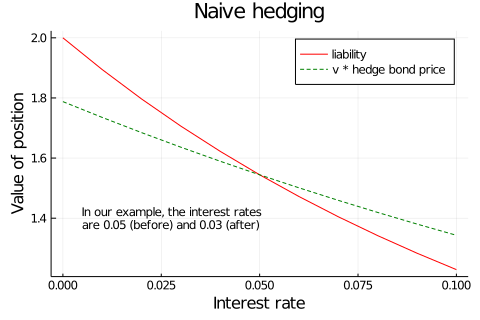

In [10]:
θ = 0:0.01:0.1        #possible ytm values

(PL,PH) = (fill(NaN,length(θ)),fill(NaN,length(θ)))
for i = 1:length(θ)
    PL[i] = BondPrice3(θ[i],cf,m)
    PH[i] = BondPrice3(θ[i],1,mH)
end

txt = "In our example, the interest rates \nare $θ₀ (before) and $θ₁ (after)"

p1 = plot( θ,[PL v*PH],
           linecolor = [:red :green],
           linestyle = [:solid :dash],
           label = ["liability" "v * hedge bond price"],
           title = "Naive hedging",
           xlabel = "Interest rate",
           ylabel = "Value of position",
           annotation = (0.005,1.4,text(txt,8,:left)) )
display(p1)

## Duration Hedging

When $D_{L}^{M}\neq D_{H}$, we could *adjust the hedge ratio* $v$ to compensate for the difference in interest rate sensitivity (duration). In particular, we could set 

$v =\frac{D_{L}^{M}}{D_{H}^{M}}\times\frac{P_{L}}{P_{H}}$. 

The balance $(P_L-hP_H)$ is kept on a money market account ($M$).

It can be shown that this gives an (approximate) hedge.

In [11]:
PH₀ = BondPrice3(θ₀,1,mH)
PH₁ = BondPrice3(θ₁,1,mH)
v = Dmac/mH * PL₀/PH₀
M = PL₀ - v*PH₀               #on money market account

ΔV = v*(PH₁-PH₀) - (PL₁-PL₀)
R  = ΔV/PL₀

printblue("Hedge bond: zero coupon bond with m=$mH and face value of 1")
xy = [PL₀,PH₀,v,v*PH₀/PL₀,Dmac,mH,M,R]
printTable(xy,[" "],["PL₀","PH₀","v","v*PH₀/PL₀","Dur(liability)","Dur(hedge)","M","Return"])

printred("Notice, the duration hedging gives a return of $(round(R*100,digits=1))%. Close to zero.")

Hedge bond: zero coupon bond with m=3 and face value of 1
                        
PL₀                1.544
PH₀                0.864
v                  3.039
v*PH₀/PL₀          1.700
Dur(liability)     5.099
Dur(hedge)         3.000
M                 -1.081
Return            -0.004

Notice, the duration hedging gives a return of -0.4%. Close to zero.


## Convexity (extra)

A second-order Taylor approximation gives that 

$
\frac{\Delta P}{P}\approx-D^{M}\times\frac{\Delta\theta}{1+\theta}+\frac{1}{2}C\times(\Delta\theta)^{2}, 
$

where 
$
C = \frac{1}{P} \frac{d^{2}P}{d\theta^{2}}
$. 

The function below calculates $C$.

In [12]:
function BondConvexity(P,cf,m,ytm)
    cdisc   = cf.*m.*(m.+1)./((1+ytm).^(m.+2)) 
    C       = sum(cdisc)/P
    return C
end

BondConvexity (generic function with 1 method)

In [13]:
C = BondConvexity(P₀,cf,m,θ₀)

printblue("Convexity")
xy = [C;Δθ;0.5*C*Δθ^2]
printTable(xy,[" "],["C";"Δθ";"0.5*C*Δθ^2"])

printred("Compare the magnitude to ΔPH/PH: ",round((PH₁-PH₀)/PH₀,digits=3))

Convexity
                    
C             35.602
Δθ            -0.020
0.5*C*Δθ^2     0.007

Compare the magnitude to ΔPH/PH: 0.059
